# 2D Bounding Box Model

In this notebook, we implement a deep neural network that takes as input monocular (left camera) KITTI images and outputs 2D bounding boxes. Our model will be a pretrained YOLO network.

In [1]:
# Import statements.
import os
import imageio
import numpy as np
from typing import Tuple, Optional
from matplotlib.pyplot import imshow
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, \
    preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, \
    preprocess_true_boxes, yolo_loss, yolo_body

Using TensorFlow backend.


In [2]:
print('Recommended TensorFlow version: 1.15.0')
print('Currently running: {0}'.format(tf.__version__))
if not tf.__version__.startswith('1.'):
    raise ValueError('This module is only compatible with TensorFlow 1.0.')

Recommended TensorFlow version: 1.15.0
Currently running: 1.15.0


In [3]:
# Global constants.
YOLO_MODEL_INPUT_SHAPE = (608, 608, 3)
CLASS_NAMES = read_classes('model_data/coco_classes.txt')
ANCHORS = read_anchors('model_data/yolo_anchors.txt')
YOLO_MODEL_PATH = 'yolo_model/yolo.h5'

In [4]:
def yolo_filter_boxes(
    box_confidence: np.ndarray,
    boxes: np.ndarray,
    box_class_probs: np.ndarray,
    threshold: float = 0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Filters YOLO boxes by thresholding on object and class confidence.
    :param box_confidence: The confidences associated with each anchor box; a
    tensor of shape (19, 19, 5, 1), where each entry is the probability that an
    object was detected in each of the 5 anchor boxes for that cell.
    :param boxes: The midpoint and dimensions (x, y, height, width) of each
    bounding box; a tensor of shape (19, 19, 5, 4).
    :param box_class_probs: The probability that the detected object (if any)
    belongs to each class; a tensor of shape (19, 19, 5, 80).
    :param threshold: If the highest class score (box confidence * class
    probability) is lower than the threshold, remove the corresponding box.
    :return: A 3 tuple of scores, boxes, and classes for the best boxes. Scores
    contains the class probability scores for selected boxes; a tensor of shape
    (None,). Boxes contains the coordinates (midpoint, height, and width) of
    selected boxes; a tensor of shape (None, 4). Classes contains the index of
    the class detected by the selected boxes; a tensor of shape (None,). None is
    the number of selected boxes, which varies based on the input image.
    """
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    # TODO use the argmax results as indices, rather than recomputing the max.
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores  = box_class_scores[filtering_mask]
    boxes   = boxes[filtering_mask]
    classes = box_classes[filtering_mask]
    return scores, boxes, classes

In [5]:
def iou(box1: Tuple[float, float, float, float],
        box2: Tuple[float, float, float, float]) -> float:
    """Returns the intersection over union (IoU) between box1 and box2.
    :param box1: The first box, (x1, y1, x2, y2) where (x1, y1) is the upper
    left corner and (x2, y2) is the lower right corner. These are normalized on
    the size of the image, so that x and y are in the interval [0, 1].
    :param box2: The second box, (x1, y1, x2, y2) where (x1, y1) is the upper
    left corner and (x2, y2) is the lower right corner. These are normalized on
    the size of the image, so that x and y are in the interval [0, 1].
    :return: The intersection over union metric.
    """
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_width  = max(xi2-xi1, 0)
    inter_height = max(yi2-yi1, 0)
    inter_area = inter_width * inter_height
    box1_area  = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area  = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

In [6]:
def yolo_non_max_suppression(
    scores: np.ndarray,
    boxes: np.ndarray,
    classes: np.ndarray,
    max_boxes: int = 10,
    iou_threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the scores, boxes, and classes detected after non-max
    suppression on the detected boxes.
    :param scores: The filtered box scores, output of yolo_filter_boxes().
    :param boxes: The filtered boxes, output of yolo_filter_boxes().
    :param classes: The filtered box classes, output of yolo_filter_boxes().
    :param max_boxes: The maximum number of predicted boxes.
    :param iou_threshold: The threshold on which to filter boxes. On each
    iteration of the tf.image.non_max_suppression algorithm, boxes whose IoU
    with the highest scoring box exceeds this value are filtered.
    :return: A tuple of scores, boxes, classes, each of whose first shape
    dimension equals the number of boxes found after applying non-max
    suppression.
    """
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes,
                                               iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

In [7]:
def yolo_eval(
    yolo_outputs: Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    image_shape: Tuple[float, float] = (720., 1280.),
    max_boxes: int= 10,
    score_threshold: float = 0.6,
    iou_threshold: float = 0.5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the filtered and non-max suppressed outputs of the YOLO model.
    :param yolo_outputs: The ouput of the YOLO model. Contains 4 tensors:
    box_confidence, box_xy, box_wh, box_class_probs.
    :param image_shape: The shape of the input image as a 2-tuple of (height,
    width).
    :param max_boxes: The maximum number of predicted boxes.
    :param score_threshold: The score threshold for filtering YOLO boxes.
    :param iou_threshold: The IoU threshold for non-max suppression.
    :return: A tuple of scores, boxes, classes for the boxes found by YOLO after
    applying filtering and non-max suppression.
    """
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes,
                                               box_class_probs,
                                               threshold=score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(
        scores, boxes, classes, max_boxes=max_boxes,
        iou_threshold=iou_threshold)
    return scores, boxes, classes

In [8]:
def predict_on_image(
    yolo_model: tf.keras.Model,
    sess: tf.Session,
    image_file: str,
    verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Runs the YOLO graph stored in the session on the image.
    :param yolo_model: The YOLO model.
    :param sess: The TensorFlow/Keras session containing the YOLO graph.
    :param image_file: The path to an image file on which to predict.
    :param verbose: If True, prints info to the console.
    :return: A tuple of scores, boxes, classes for the boxes found by YOLO.
    """
    image, image_data = preprocess_image(
        image_file, model_image_size = YOLO_MODEL_INPUT_SHAPE[:2])
    yolo_outputs = yolo_head(yolo_model.output, ANCHORS, len(CLASS_NAMES))
    image_size_h_w = tuple([float(dim) for dim in image.size[::-1]])
    scores, boxes, classes = yolo_eval(yolo_outputs, image_size_h_w)
    out_scores, out_boxes, out_classes = sess.run(
        fetches = [scores, boxes, classes],
        feed_dict = {
            yolo_model.input: image_data,
            K.learning_phase(): 0})
    if verbose:
        print('Found {0} boxes for {1}'.format(len(out_boxes), image_file))
    return out_scores, out_boxes, out_classes

In [9]:
def display_yolo_boxes(image_file: str, out_scores: np.ndarray,
                       out_boxes: np.ndarray, out_classes: np.ndarray,
                       save_file: Optional[str] = None) -> None:
    """Displays the YOLO boxes output from prediction on the image.
    :param image_file: The path to the image file.
    :param out_scores: The scores output from the YOLO model prediction.
    :param out_boxes: The boxes output from the YOLO model prediction.
    :param out_classes: The class probabilities output from the YOLO model
    prediction.
    :param save_file: If specified, the location at which to save the output
    image.    
    """
    print('Found {0} boxes for {1}'.format(len(out_boxes), image_file))
    image, image_data = preprocess_image(
        image_file, model_image_size = YOLO_MODEL_INPUT_SHAPE[:2])
    colors = generate_colors(CLASS_NAMES)
    draw_boxes(image, out_scores, out_boxes, out_classes, CLASS_NAMES, colors)
    if save_file:
        image.save(save_file, quality=90)
    imshow(image)

In [10]:
def get_yolo_model(model_save_file: str) -> tf.keras.Model:
    """Returns the YOLO model stored at the given h5 file. This is just for user
    convenience.
    :param model_save_file: The path to the YOLO model (probably yolo.h5).
    :return: The YOLO model.
    """
    return load_model(model_save_file)

In [11]:
def get_session() -> tf.Session:
    """Returns the current session. This is just for user convenience.
    :return: The current session.
    """
    return K.get_session()

In [12]:
sess = K.get_session()
yolo_model = get_yolo_model(YOLO_MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




/Users/leo/anaconda3/envs/4bai-project/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
test_image = '../data/KITTI/data_object_image_2/training/image_2/000008.png'
out_scores, out_boxes, out_classes = predict_on_image(yolo_model, sess,
                                                      test_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 6 boxes for ../data/KITTI/data_object_image_2/training/image_2/000008.png
car 0.64 (888, 181) (953, 236)
car 0.67 (747, 169) (804, 206)
car 0.78 (915, 197) (1232, 375)
car 0.78 (600, 171) (718, 256)
car 0.86 (0, 195) (410, 375)
car 0.89 (333, 175) (615, 360)


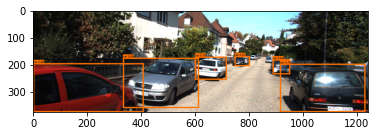

In [14]:
display_yolo_boxes(test_image, out_scores, out_boxes, out_classes,
                   save_file='test_out.png')